_version log: finding new ways to measure the angle. This has become the main version for narrowband._

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import pandas as pd
from scipy import signal, interpolate
plt.rcParams.update({'font.size':14})

pixel_pitch = 9.9 #um

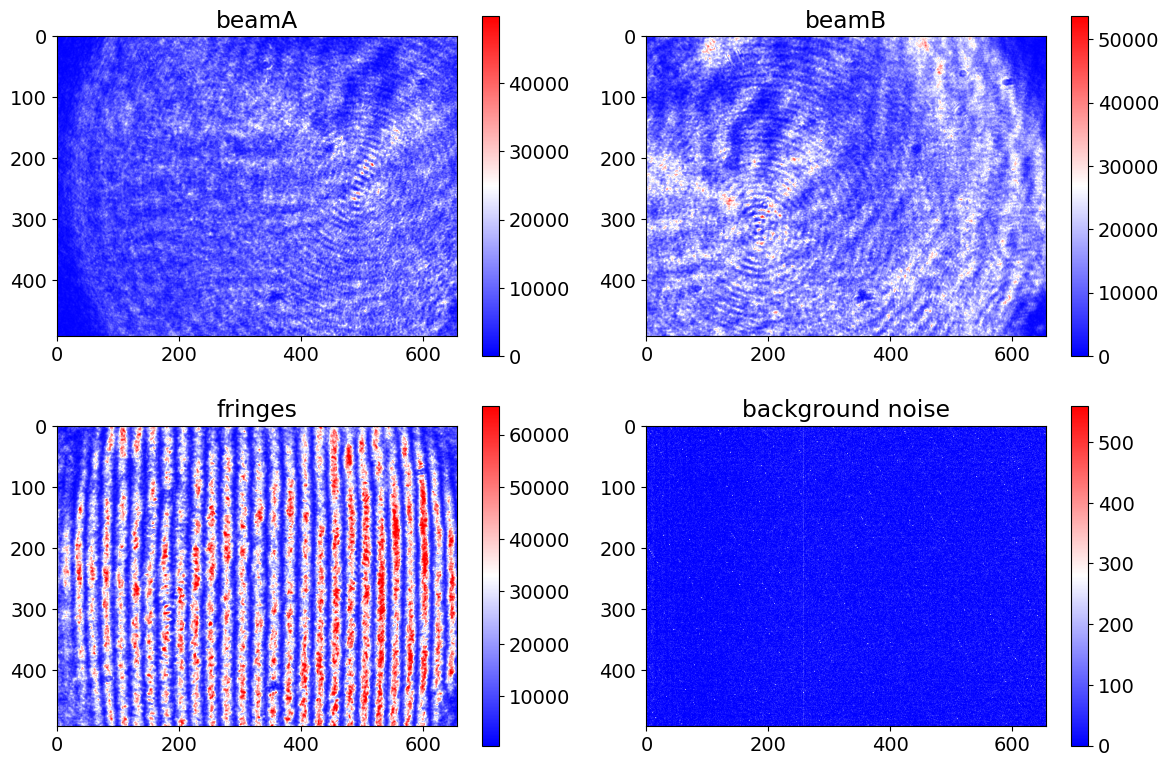

In [31]:
def import_standard_tif(colour, number):
    im = Image.open('data\\'+colour+'_fringes'+number+'.tif')
    fringes = np.array(im, dtype= np.float32)
    im = Image.open('data\\'+colour+'_BA'+number+'.tif')
    beamA = np.array(im, dtype= np.float32)
    im = Image.open('data\\'+colour+'_BB'+number+'.tif')
    beamB = np.array(im, dtype= np.float32)
    im = Image.open('data\\'+colour+'_bg'+number+'.tif')
    background = np.array(im, dtype= np.float32)
    return fringes, beamA, beamB, background

fringes, beamA, beamB, background = import_standard_tif("green", "6")

plt.figure(figsize= (12,8))

plt.subplot(2,2,1)
im=plt.imshow(beamA, cmap='bwr')
plt.colorbar(im)
plt.title("beamA")

plt.subplot(2,2,2)
im=plt.imshow(beamB, cmap='bwr')
plt.colorbar(im)
plt.title("beamB")

plt.subplot(2,2,3)
im=plt.imshow(fringes, cmap='bwr')
plt.colorbar(im)
plt.title("fringes")

plt.subplot(2,2,4)
im=plt.imshow(background, cmap='bwr')
plt.colorbar(im)
plt.title("background noise")

plt.tight_layout()
plt.show()

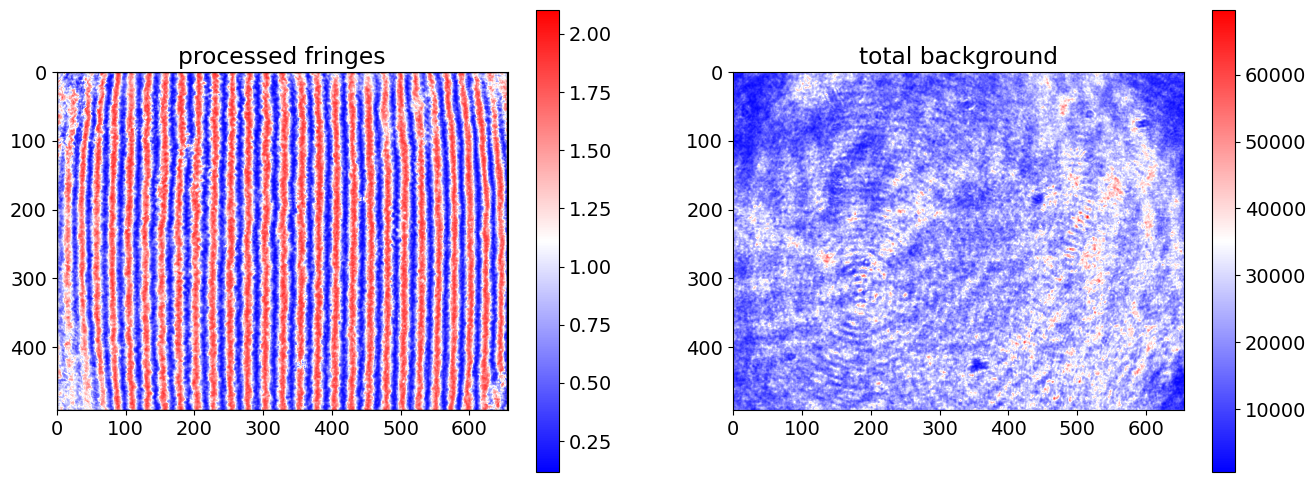

In [32]:
ROI = [[0,491],[0,655]] #region of interest in rows, columns. [[0,491],[0,655]]

nofringes = beamA +beamB -background

if False: #toggle which meathod you want to use. IDK which one is better.
    beamPost = fringes - nofringes #take away background. This meathod exaggerates the bandwidth.
else:
    beamPost = fringes / nofringes #normalise using background. This meathod suffers with div0 errors and exaggerates the noise.
    beamPost = np.nan_to_num(beamPost, #This is unphysical but so is infinate intensity.
                            posinf= np.nanmax(beamPost[np.isfinite(beamPost)]), #occors for x/0
                            neginf= np.nanmin(beamPost[np.isfinite(beamPost)]), #occors for -x/0. this should be impossible
                            nan= 0) #occors for 0/0

plt.figure(figsize = (16,6))

ax = plt.subplot(1,2,1)
im=plt.imshow(beamPost, cmap='bwr')
plt.colorbar(im)
plt.title("processed fringes")

# Create a Rectangle patch
rect = patches.Rectangle((ROI[1][0], ROI[0][0]), ROI[1][1]-ROI[1][0], ROI[0][1]-ROI[0][0], linewidth=1, edgecolor='k', facecolor='none')
ax.add_patch(rect)

plt.subplot(1,2,2)
im=plt.imshow(nofringes, cmap='bwr')
plt.colorbar(im)
plt.title("total background")

plt.show()

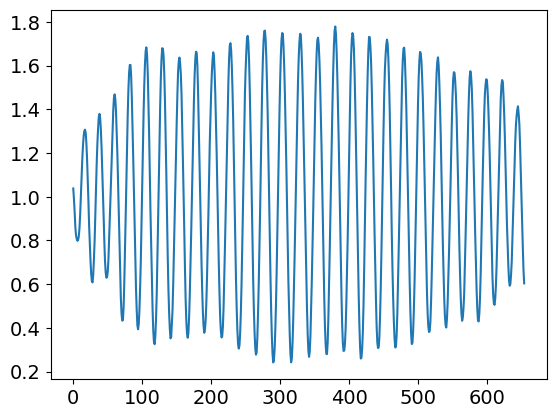

In [33]:
average_signal = np.mean(beamPost[ROI[0][0]:ROI[0][1], ROI[1][0]:ROI[1][1]], axis = 0)

plt.plot(average_signal)
plt.show()


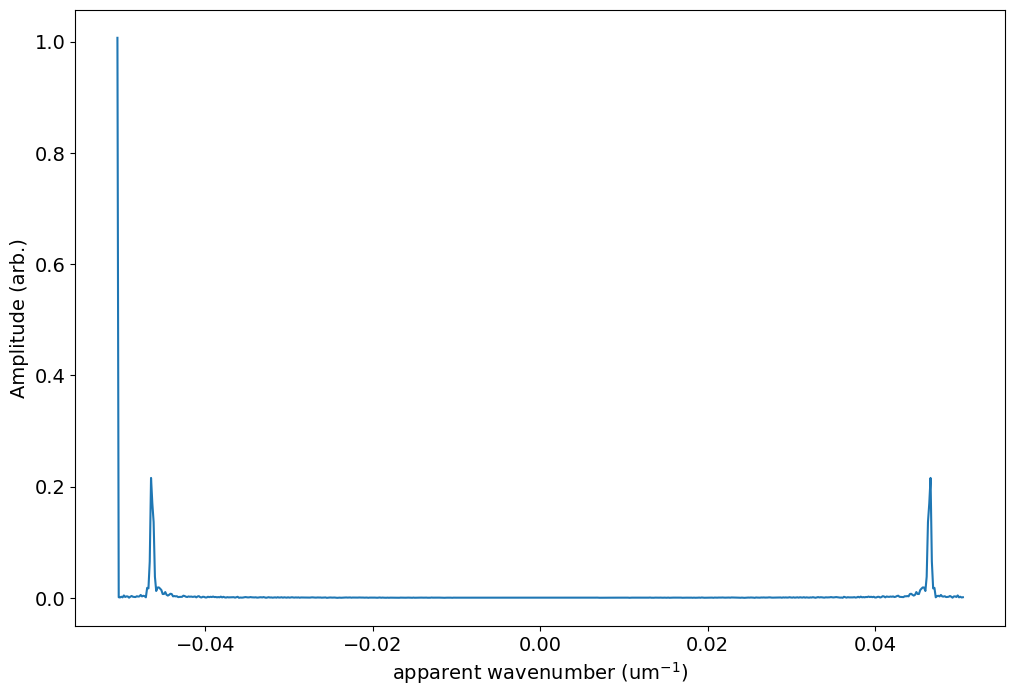

In [34]:
FT = np.fft.fft(average_signal, norm = "forward")

num_of_freqs = len(FT)//2 +1
samples = len(FT)
freqs = np.linspace(-1/2/pixel_pitch, 0, num_of_freqs) #niquist frequency = 1/2 * 1/pixel_pitch
freqs = np.concatenate((freqs, -freqs[-2::-1]))
freqs = freqs[:len(FT)]

plt.figure(figsize = (12,8))
plt.subplot(1, 1, 1)

plt.plot(freqs,
        abs(FT))

plt.xlabel('apparent wavenumber (um$^{-1}$)')
plt.ylabel('Amplitude (arb.)')

plt.show()

C:\Users\syf83691\AppData\Local\Temp\ipykernel_16660\963838433.py:18: RuntimeWarning: divide by zero encountered in divide
  wavelengths = -1/freqs[:-num_of_freqs +1]


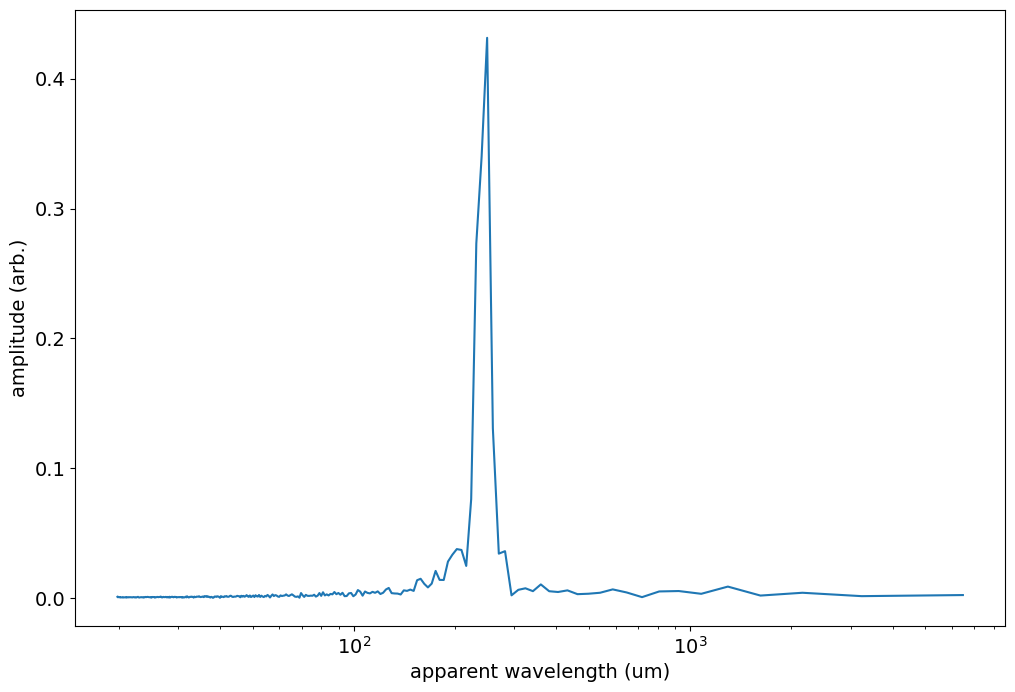

In [35]:
#FT = np.fft.fftshift(FT) #rearranges the array such that 0,0 at the beginning

#assign amplitudes from fft coeffients. Check how elin does this. (She is smarter than me!)
amplitude = np.zeros(num_of_freqs)
amplitude[0] = np.abs(FT[0])

if (samples//2 == samples/2): #if even
        amplitude[num_of_freqs-1] = np.abs(FT[num_of_freqs-1])
        amplitude[1:-1] = (np.abs( FT[1:num_of_freqs-1] ) +
                        np.abs( FT[:num_of_freqs-1:-1] ))

        wavelengths = -1/freqs[:-num_of_freqs +2]

else: #if odd
        amplitude[1:] = (np.abs( FT[1:num_of_freqs] ) +
                        np.abs( FT[:num_of_freqs-1:-1] ))

        wavelengths = -1/freqs[:-num_of_freqs +1]

amplitude = amplitude[::-1] #the largest wavelength is the smallest frequency so the order needs to be reversed

plt.figure(figsize = (12,8))
plt.subplot(1, 1, 1)

plt.plot(wavelengths[:-1], #excule the infinate wavelength
        amplitude[:-1])
plt.xlabel('apparent wavelength (um)')
plt.ylabel('amplitude (arb.)')
plt.xscale("log")
plt.show()

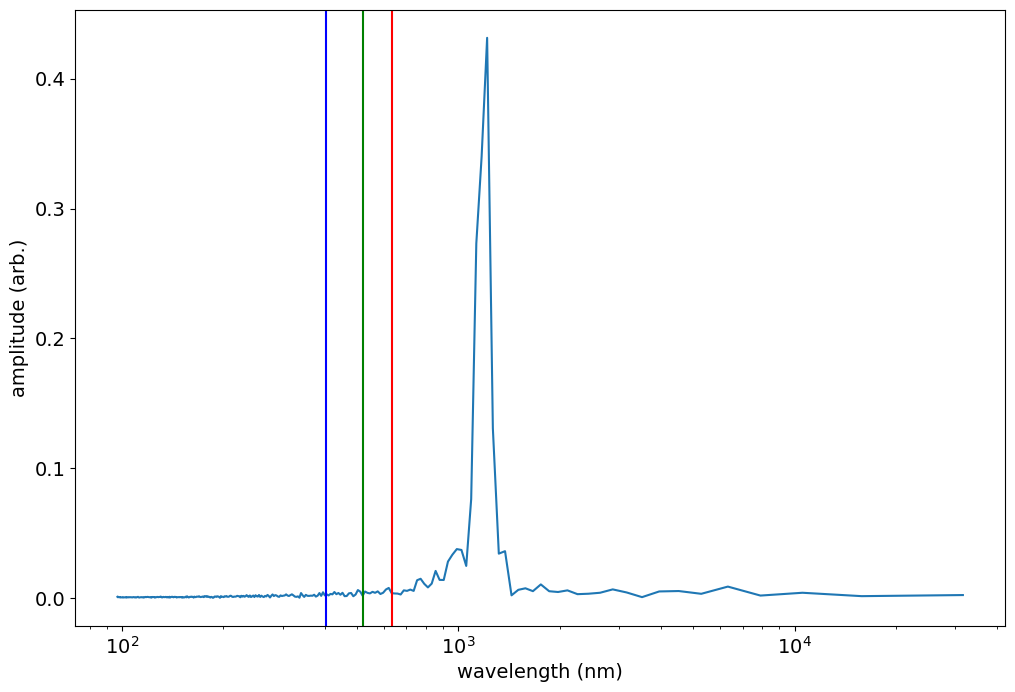

In [39]:
################COMPENSATE FOR ANGLE#################

angle_between_beams = 0.28 # =2*theta. in degrees. Has a large uncertainty

theta = angle_between_beams/2 *np.pi/180 #in radians
corrected_wavelengths = wavelengths *2*np.sin(theta)

plt.figure(figsize = (12,8))
plt.subplot(1, 1, 1)

plt.plot(corrected_wavelengths[:-1] *1e3, #excule the infinate wavelength and convert to nm
        amplitude[:-1])
plt.xlabel('wavelength (nm)')
plt.ylabel('amplitude (arb.)')
plt.xscale("log")
plt.axvline(405, color = "blue")
plt.axvline(520, color = "green")
plt.axvline(635, color = "red")
#plt.xlim(200, 800)
plt.show()

In [37]:
#################FINDING LARGEST AMPLITUDES############

df = np.stack([amplitude,
                corrected_wavelengths])
df = np.transpose(df)

df = pd.DataFrame(df, columns = ["amplitude","wavelength"])
df.sort_values("amplitude", ascending = False, inplace = True)
df.reset_index(drop = True, inplace = True)
df.head(10) #show the top 10 wavelengths

,amplitude,wavelength
0,1.007168,-inf
1,0.431439,0.825791
2,0.339947,0.795207
3,0.273101,0.766806
4,0.130814,0.858823
5,0.076316,0.740365
6,0.037807,0.670956
7,0.037137,0.692599
8,0.036198,0.933503
9,0.034306,0.894607


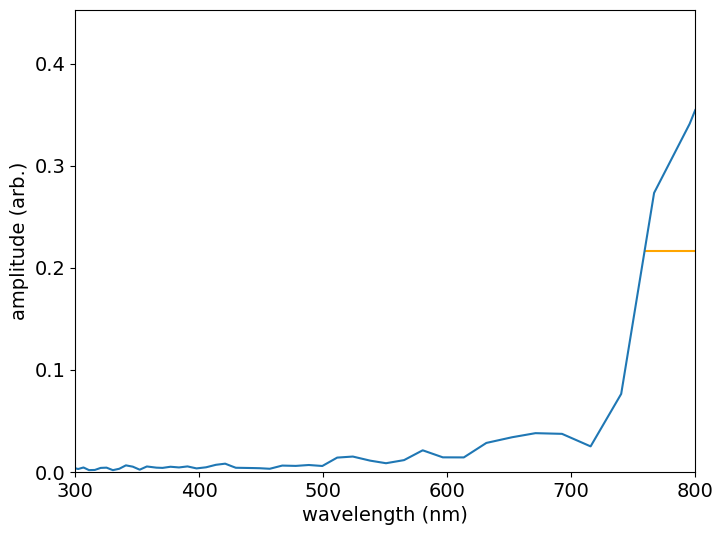

[825.74787958]
[155.96967243]


In [38]:
################FINDING PEAKS AND FWHM#####################

n = 100_000 #how many liniarlly spaced points to plot. It has to be liniar in order to be able to convert from indexes to um
relative_prominence = 1e-1 #this should be at least 1 / the S:N ratio.

spectrum_function = interpolate.interp1d(corrected_wavelengths[:-1], amplitude[:-1])
x = np.linspace(corrected_wavelengths[0], corrected_wavelengths[-2], n)
y = spectrum_function(x)

peaks, peak_properties = signal.find_peaks(y, prominence = relative_prominence*y.max()) #prominence = the smallest peak that can be considered a signal rather than noise. It would be nice to calculate this.
FWHM = signal.peak_widths(y, peaks, rel_height=0.5) #gives the FWHM in terms of indexes
FWHM = np.vstack(FWHM)

peaks = peaks * (corrected_wavelengths[-2] - corrected_wavelengths[0]) /n + corrected_wavelengths[0] #convert to um
FWHM[np.arange(len(FWHM))!=1] = FWHM[np.arange(len(FWHM))!=1] * (corrected_wavelengths[-2] - corrected_wavelengths[0]) /n + corrected_wavelengths[0] #convert to um.
FWHM[np.arange(len(FWHM))!=1] = FWHM[np.arange(len(FWHM))!=1]*1e3 #convert to nm. FWHM[np.arange(len(FWHM))!=1] will exclude index 1 (height of FWHM)

plt.figure(figsize = (8,6))
plt.subplot(1, 1, 1)

plt.xlabel('wavelength (nm)')
plt.ylabel('amplitude (arb.)')
#plt.xscale("log")
plt.hlines(*FWHM[1:,:], color = "orange")
plt.vlines(x= peaks*1e3,
           ymin= spectrum_function(peaks) - peak_properties["prominences"],
           ymax= spectrum_function(peaks), 
           color= "orange")
plt.plot(x *1e3,
        y)

plt.xlim(3e2, 8e2)
plt.ylim(0)

plt.show()

print(peaks*1e3) # in nm
print(FWHM[0])